In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('calibration_wide/GO*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Test New Image

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('calibration_wide/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


undistorted = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',undistorted)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

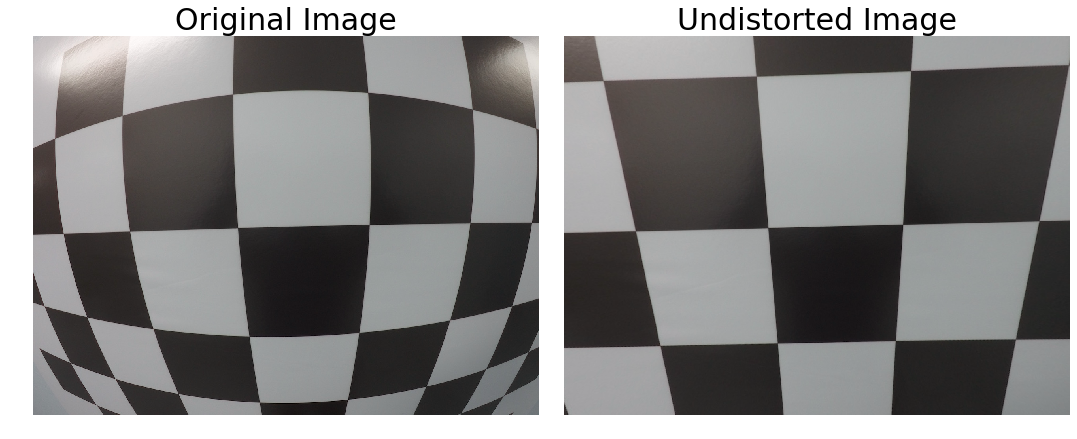

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
f.tight_layout()
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
ax1.imshow(img)

ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=0.6, top=0.9, bottom=0.)
ax2.axis('off')
ax2.imshow(undistorted)

## Load the Data

In [5]:
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "calibration_wide/wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

# Read in an image
img = cv2.imread('calibration_wide/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

## Undistorion Function

In [6]:
# The function takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)

## Show the Image

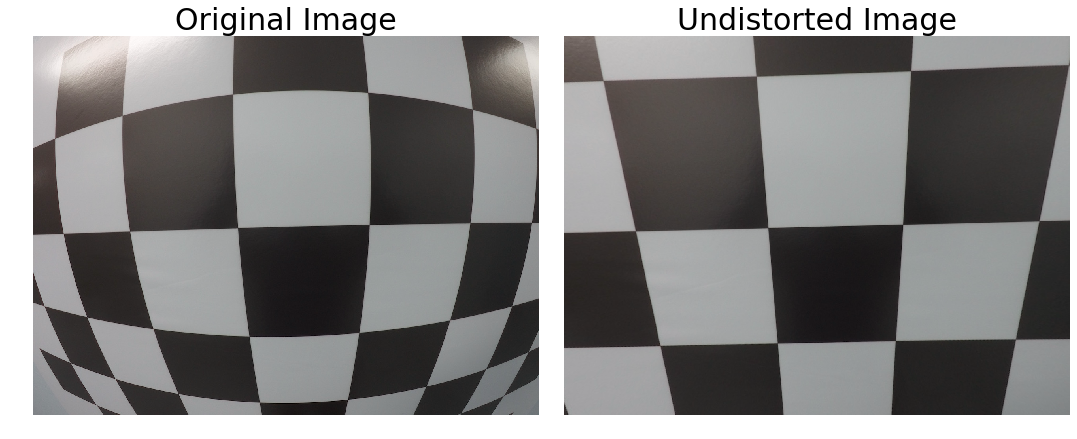

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
f.tight_layout()
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
ax1.imshow(img)

ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=0.6, top=0.9, bottom=0.)
ax2.axis('off')
ax2.imshow(undistorted)

## Calculating Lane Curvature

Self-driving cars need to be told the correct steering angle to turn, left or right. You can calculate this angle if you know a few things about the speed and dynamics of the car and how much the lane is curving.

One way to calculate the curvature of a lane line, is to fit a 2nd degree polynomial to that line, and from this you can easily extract useful information.

For a lane line that is close to vertical, you can fit a line using this formula: f(y) = Ay^2 + By + C, where A, B, and C are coefficients.

A gives you the curvature of the lane line, B gives you the heading or direction that the line is pointing, and C gives you the position of the line based on how far away it is from the very left of an image (y = 0).

### Perspective Transform

```python
Compute the perspective transform, M, given source and destination points:
M = cv2.getPerspectiveTransform(src, dst)

Compute the inverse perspective transform:
Minv = cv2.getPerspectiveTransform(dst, src)

Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
```

In [8]:
def wrp(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Four source coordinates
    src = np.float32([[850,320],[865,450],[533,350],[535,210]])
    
    # Four desired coordinates
    dst = np.float32([[870,240],[870,370],[520,370],[520,240]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warp

(960, 1280, 3)


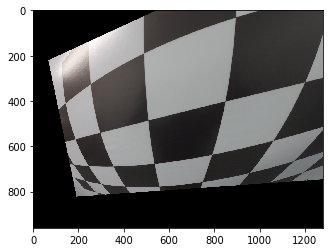

In [9]:
warped_img = wrp(img)
print(warped_img.shape)
plt.imshow(warped_img)